In [1]:
import numpy as np
import random
import itertools as it
import os, subprocess
import time

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mycolorpy import colorlist as mcp

import proplot as pplt

from UQpy.distributions import Normal, Uniform, JointIndependent

import scipy
from scipy.integrate import odeint

from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 16
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.1
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.titlesize'] = 17

pplt.rc['grid.linewidth'] = 0.3
pplt.rc['grid.alpha'] = 0.3

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")


# Lottka-Volterra model:

The classic Lotka-Volterra dynamical system, (the predator-prey equations), describes the dynamics of a biological system in which two species: a prey (e.g., rabbits) and a predator (e.g., foxes) interract.

$$\frac{du}{dt} = \alpha u − \beta uv$$
$$\frac{dv}{dt} =\delta uv−\gamma v$$

where $u$ is the prey population, $v$ is the predator population and $\alpha,\beta,\gamma,\delta$ are stochastic model parameters: 


- Population of prey species: $u, u(t = 0) = 10$

- Population of predator species: $v,  v(t = 0) = 5$

- Natural growing rate of preys when no predator exists: $\alpha \sim U(0.90,1)$

- Natural dying rate of preys due to predation: $\beta \sim U (0.10, 0.15)$

- Natural dying rate of predator when no prey exists $\gamma = 1.50$ 

- Reproduction rate of predators per prey eaten $\delta = 0.75$

In [2]:
def Lotka_Volterra(a, b, c, d, t):
    
    X_f0 = np.array([     0. ,  0.])

    def dX_dt(X, t=0):
        """ Return the growth rate of fox and rabbit populations. """
        return np.array([ a*X[0] -   b*X[0]*X[1] ,  
                      -c*X[1] + d*b*X[0]*X[1] ])
    
    # Initials conditions: 10 rabbits and 5 foxes  
    X0 = np.array([10, 5]) 

    X, infodict = scipy.integrate.odeint(dX_dt, X0, t, full_output=True)
    
    return X

In [3]:
n_samples = 600

# probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a 
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

# drawing samples: input
x = joint.rvs(n_samples)

n = 512
n2 = 2*n

# time steps
t = np.linspace(0, 25,  n) 

out = []

for i in range(x.shape[0]):
    out_ = Lotka_Volterra(x[i, 0], x[i, 1], c, d, t)
    # keeping both species
    out_ = out_.T.flatten() 
    out.append(out_)

data = np.array(out)
data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [4]:
print('Input array (x):')
print(x)

Input array (x):
[[1.03693123 0.17707878]
 [0.91097192 0.17269559]
 [1.00983133 0.15334108]
 ...
 [1.0264013  0.12137236]
 [0.99176723 0.10095574]
 [0.98191396 0.1046772 ]]


In [5]:
print('Initial shape of the output array:')
print(np.asarray(out).shape)

Initial shape of the output array:
(600, 1024)


In [6]:
print('The shape of the output array after reshaping:')
print(data.shape)

The shape of the output array after reshaping:
(600, 32, 32)


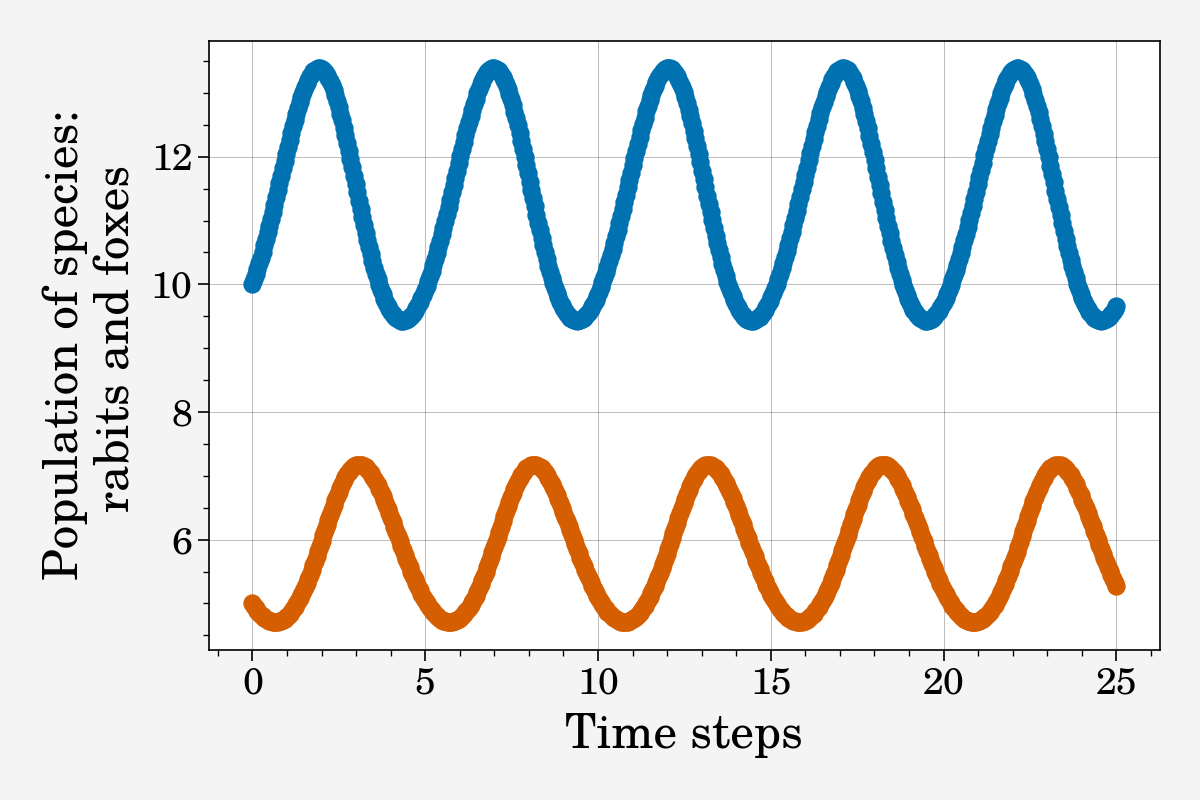

In [7]:
plt.scatter(t, out[0][:n])
plt.scatter(t, out[0][n:])
plt.xlabel('Time steps')
plt.ylabel('Population of species:\n rabits and foxes')
plt.tight_layout()
plt.show()

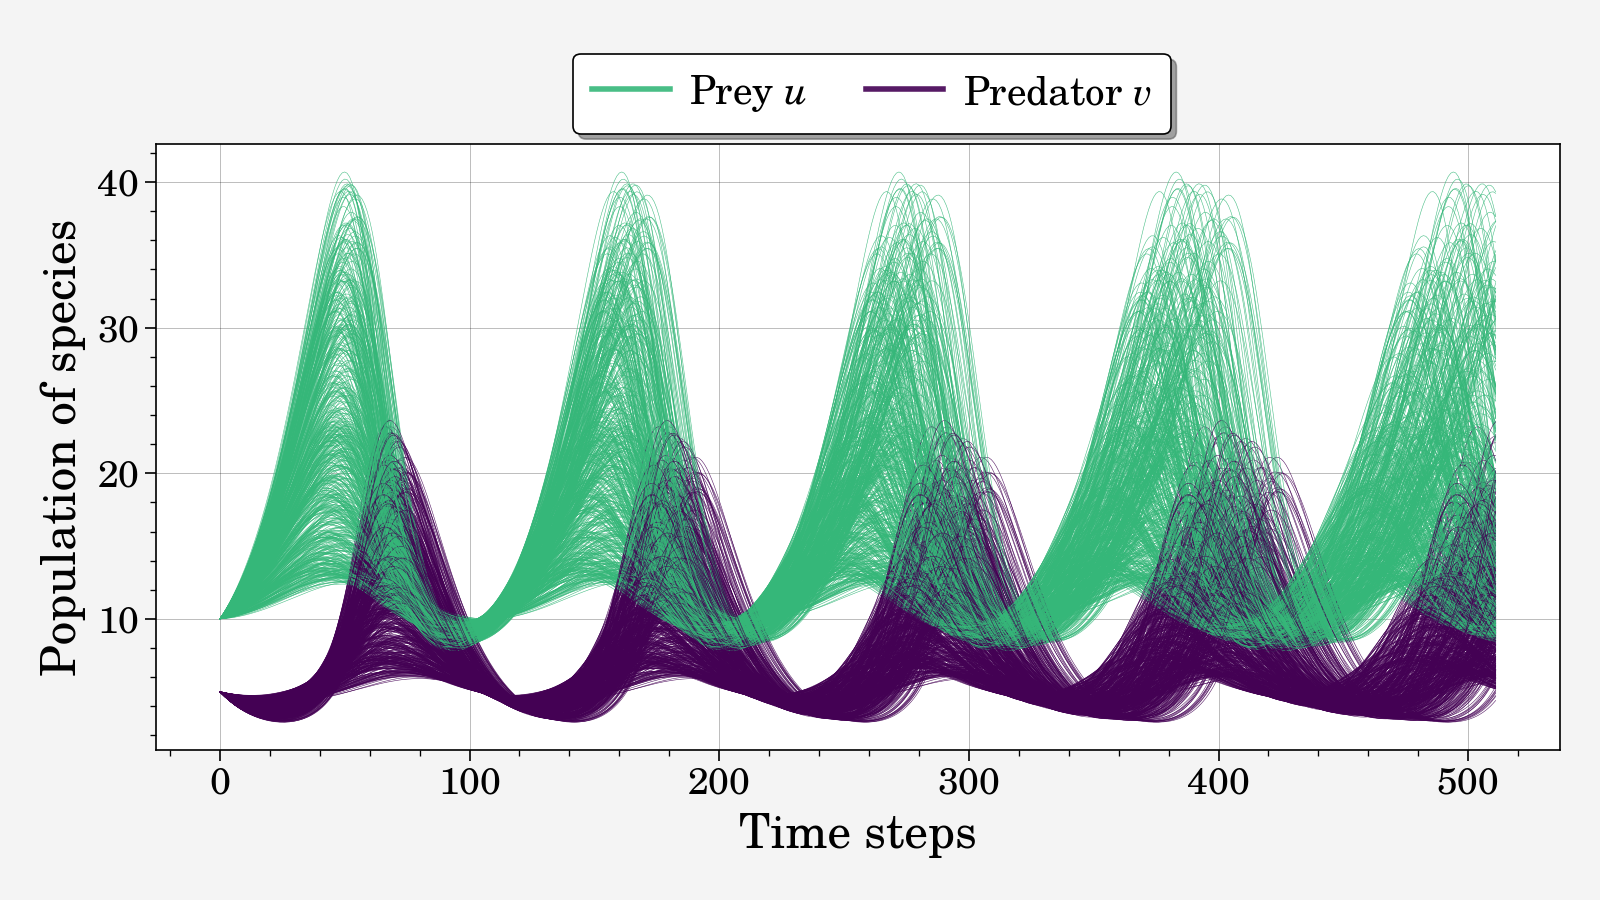

In [8]:
colors=mcp.gen_color(cmap='viridis',n=4)

fig, ax = plt.subplots(figsize=(8, 4.5))

i_sol = 0
for i in range(np.asarray(out).shape[0]):
    ax.plot(out[i][:n], color=colors[2], alpha=0.9, lw=0.2, 
            label=('Prey $u$' if i_sol==0 else None))
    ax.plot(out[i][n:], color=colors[0], alpha=0.9, lw=0.2, 
            label=('Predator $v$' if i_sol==0 else None))
    i_sol += 1
ax.set_xlabel('Time steps')
ax.set_ylabel('Population of species')
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.51, 1.15),
                ncol=2, fancybox=True, shadow=True, fontsize=14)
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.tight_layout()
plt.savefig('plots/SI/LV_600.png', dpi=800, bbox_inches='tight')
plt.show()

In [9]:
ranks = [np.linalg.matrix_rank(data[i]) for i in range(len(data))]
unique, counts = np.unique(ranks, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 31   5]
 [ 32 595]]


In [10]:
if not os.path.exists(f'GSA_results/LV/2vars_PCE_1_iter.npz'):
    start_time = time.time()

    # performing GDMAps
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                             n_evecs=20,
                                                             n_keep=3, 
                                                             p=10).get() 
    # performing PCE on the manifold
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=6, 
                          verbose=True).get()

    print('Error of PCE:', error)
    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    np.savez(f'GSA_results/LV/2vars_PCE_1_iter.npz',
                 x1 = g, 
                 x2 = coord, 
                 x3 = residuals, 
                 x4 = index,
                 x5 = evals,
                 x6 = evecs,
                 x7 = error)
    
else:
    file_res = np.load(f'GSA_results/LV/2vars_PCE_1_iter.npz', 
                       allow_pickle=True)
    
    g = file_res['x1']
    coord = file_res['x2']
    residuals = file_res['x3']
    index = file_res['x4']
    evals = file_res['x5']
    evecs = file_res['x6']
    error = file_res['x7']



## GDMaps outputs:

In [11]:
print('Diffusion coordinates (shape):')
print(g.shape)

Diffusion coordinates (shape):
(600, 3)


In [12]:
# coord = index[1:self.n_parsim + 1]
print('Coordinates trucated:')
print(coord)

Coordinates trucated:
[1 2 5]


In [13]:
print('Residuals: used to identify the most parsimonious low-dimensional representation')
print(residuals)

Residuals: used to identify the most parsimonious low-dimensional representation
[       nan 1.         0.61274956 0.16700093 0.18383943 0.21622359
 0.13294272 0.10107236 0.12680182 0.0686146  0.09736103 0.11094053
 0.12337576 0.10459837 0.06131069 0.03760875 0.04847053 0.07000955
 0.04496539 0.04626452]


In [14]:
print('Indices of the eigenvalues associated with each residual:')
print(index)

Indices of the eigenvalues associated with each residual:
[ 0  1  2  5  4  3  6  8 12 11 13  7 10 17  9 14 16 19 18 15]


In [15]:
print('Eigenvalues from DiffusionMaps.mapping():')
print(evals)

Eigenvalues from DiffusionMaps.mapping():
[1.         0.17487207 0.08262912 0.04759044 0.03552628 0.02461165
 0.01800718 0.01459185 0.01045466 0.00787704 0.00625581 0.00574656
 0.0052474  0.00450244 0.00427533 0.00386678 0.00320182 0.00291628
 0.00289913 0.00249786 0.00237243]


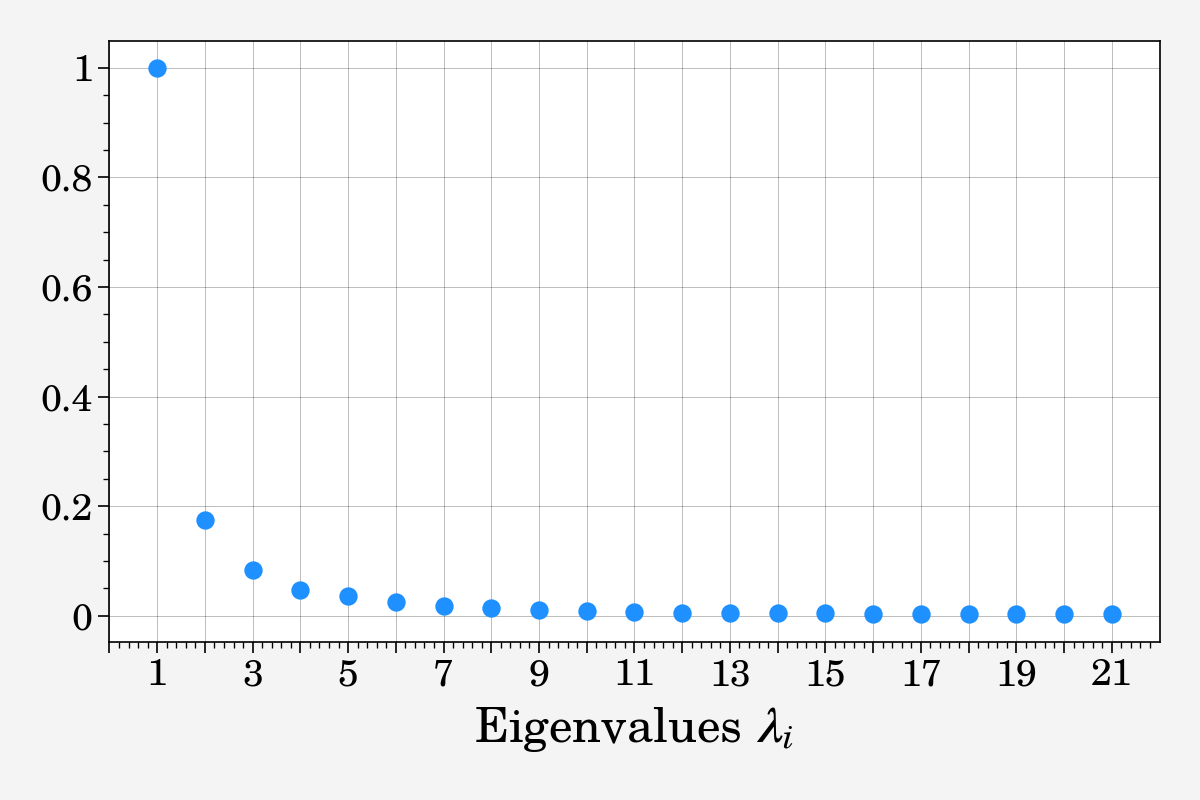

In [16]:
# scree-plot with a trivial (first eigenvelue)
plt.scatter(np.arange(1, len(evals)+1, 1), evals, c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$')
xticks = np.arange(len(evals)+1)
plt.xticks(xticks, ["{}".format(num) if num%2==1 else " " for num in xticks])
plt.tight_layout()
plt.show()

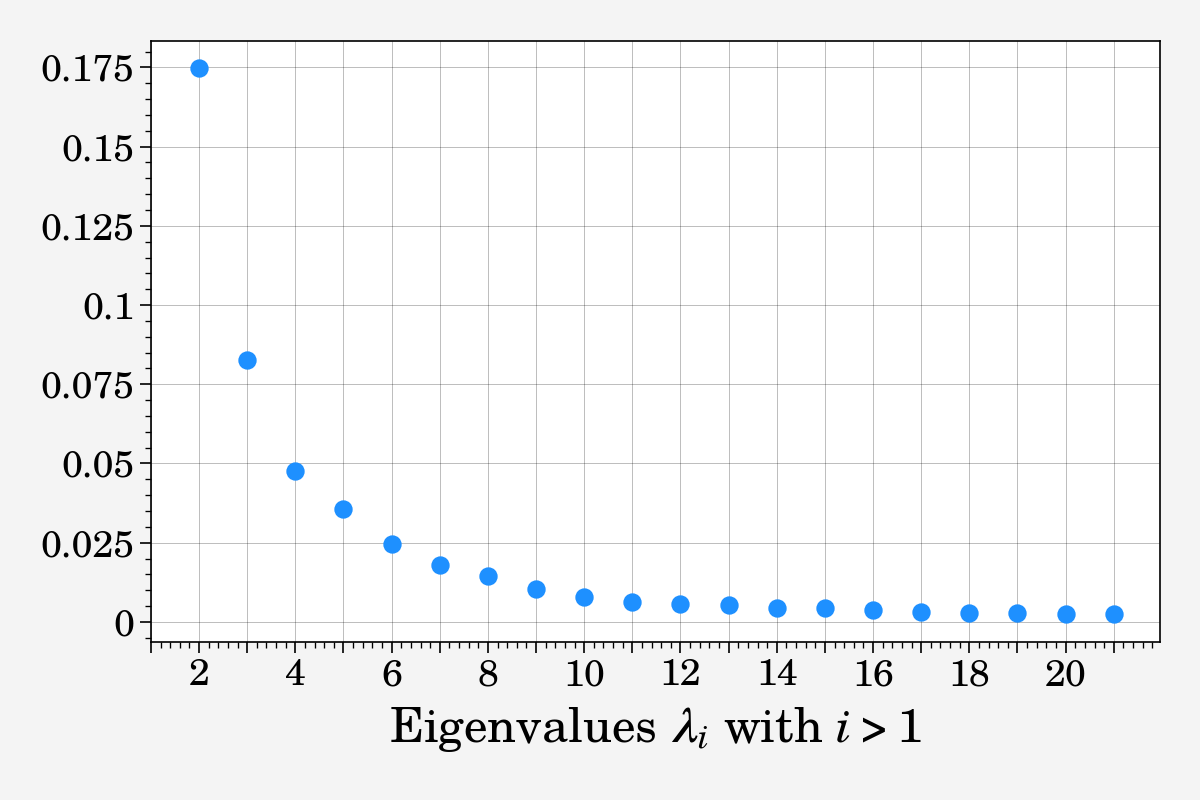

In [17]:
# scree-plot with on only non-trivial eigenvalues (excluding the first eigenvelue)
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
xticks = np.arange(1, len(evals)+1)
plt.xticks(xticks, ["{}".format(num) if num%2==0 else " " for num in xticks])
plt.tight_layout()
plt.show()

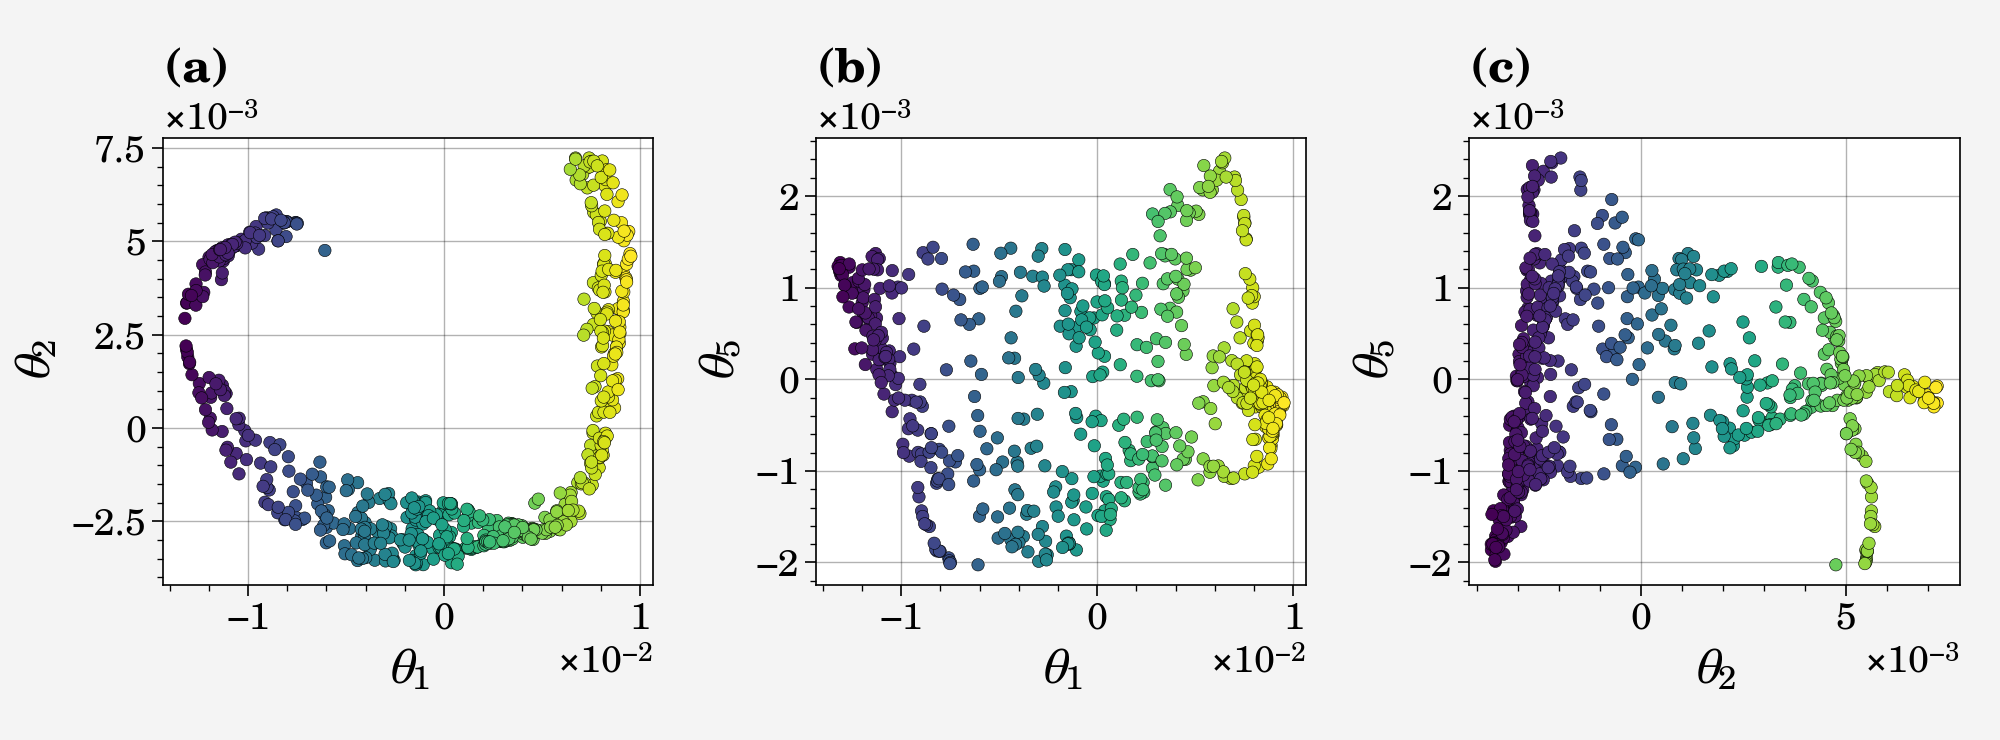

In [18]:
# plotting diffusion coordinates

pplt.rc['grid.linewidth'] = 0.5
pplt.rc['grid.alpha'] = 0.3

numbering= ['(a)', '(b)', '(c)']

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# plotting first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.7), constrained_layout=True)
    for i in range(len(comb1)):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                      cmap='viridis', s=20, 
                      edgecolors='k', 
                      linewidth=0.2)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[i][0]))
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[i][1]))
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        ax[i].set_title(r'$\bf{{{}}}$'.format(numbering[i]), loc='left', pad=20)
    fig.tight_layout()
    plt.savefig('plots/SI/LV_2vars_PCE_dcoords.png', dpi=800, bbox_inches='tight')
    plt.show()
    

# 1. Sobol' indices: LV model with two uncertain parameters

## 1.1. GSA using GDMaps PCE

In [19]:
n_iter = 50
n_uncertain_param = 2
n_d_coord = 3
n_samples = 512

if not os.path.exists('GSA_results/LV'):
    os.makedirs('GSA_results/LV')

if not os.path.exists(f'GSA_results/LV/2vars_PCE_50_iters.npz'):

    pce_total_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))
    pce_first_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))

    for i in range(n_iter):
        print('Iteration: ', i)

        x = joint.rvs(n_samples)

        out = []

        for j in range(x.shape[0]):
            out_ = Lotka_Volterra(x[j, 0], x[j, 1], c, d, t)
            # keeping both species
            out_ = out_.T.flatten() 
            out.append(out_)

        data = np.array(out)
        data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

        g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                           n_evecs=20,
                                                           n_keep=3, 
                                                           p=10).get()
        pce, error = PceModel(x=x, 
                              g=g, 
                              dist_obj=joint, 
                              max_degree=6, 
                              verbose=False).get()


        pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
        pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()

        for p in range(n_uncertain_param):
            pce_total_si[i, p, :] = pce_to_si[p]
            pce_first_si[i, p, :] = pce_fo_si[p]
                      
    np.savez(f'GSA_results/LV/2vars_PCE_50_iters.npz',
             x1 = pce_total_si, 
             x2 = pce_first_si) 
else:
    file_res = np.load(f'GSA_results/LV/2vars_PCE_50_iters.npz', 
                       allow_pickle=True)
    
    pce_total_si = file_res['x1']
    pce_first_si = file_res['x2']
    



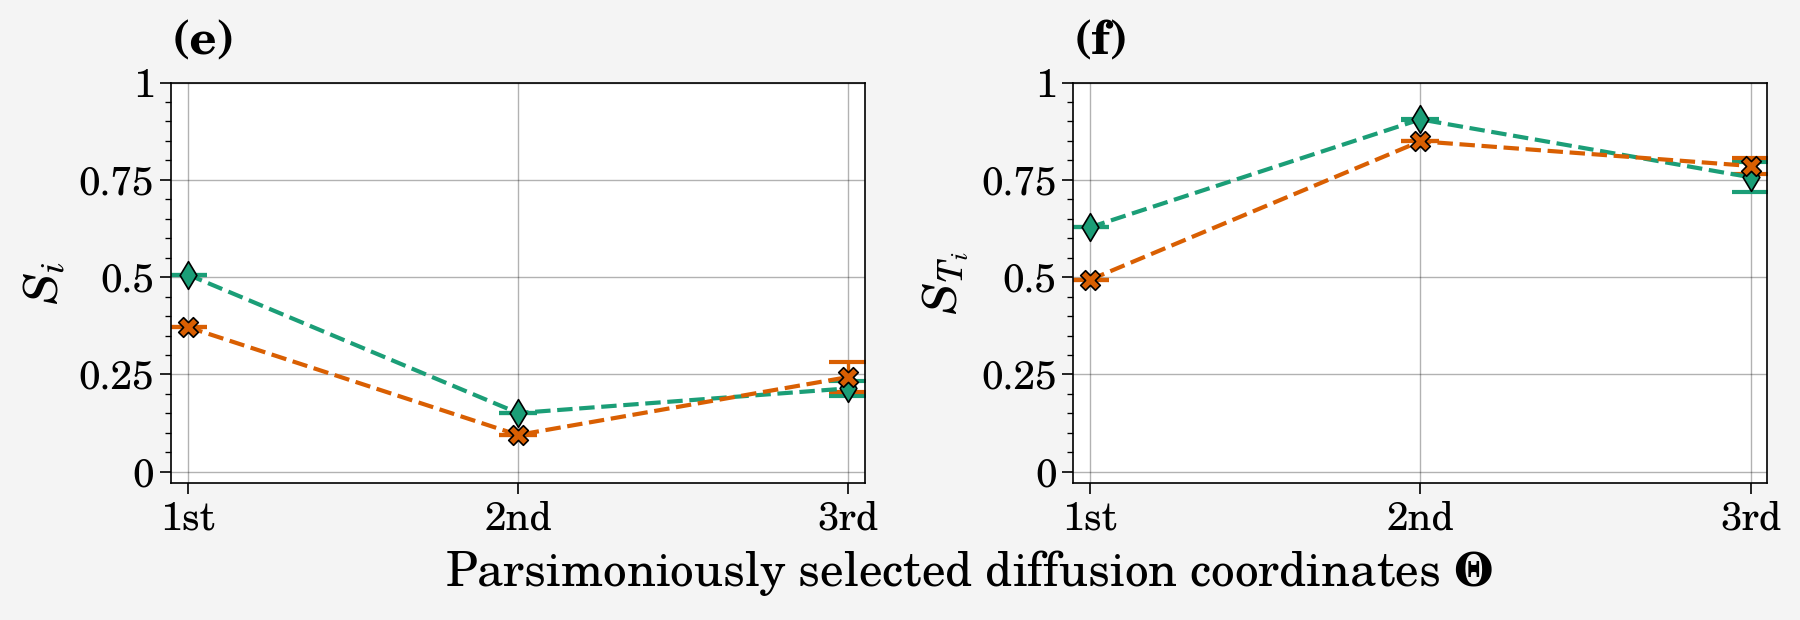

In [20]:
param_names = [r'$\alpha$', r'$\beta$']
error_marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
colors=mcp.gen_color(cmap="Dark2",n=7)

sobol_si_pce = [pce_first_si, pce_total_si]

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(9, 3.1), sharex=True, sharey=False)

for j, si in enumerate(sobol_si_pce):
    for i, param in enumerate(param_names):
        axs[j].scatter(np.linspace(1, 3, 3, dtype='int'), si.mean(axis=0)[i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(np.linspace(1, 3, 3, dtype='int'), si.mean(axis=0)[i], 
                        si.var(axis=0, ddof=1)[i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=7, alpha=1, elinewidth=1.2)

    for ax in axs:
        ax.format(xticklabels=['1st', '2nd',  '3rd'],
                  xticks = [1, 2, 3], xlim=(0.95, 3.05), ylim=(-0.03, 1),
                  xlabel=r'Parsimoniously selected diffusion coordinates $\bf{\Theta}$')
                  
        if ax == axs[1]:
            ax.format(ylabel=r'$S_{T_i}$', title='(f)', 
                      titleloc='left', titlepad=10, titleweight='bold')
        else:
            ax.format(ylabel=r'$S_i$', title='(e)', 
                      titleloc='left', titlepad=10, titleweight='bold')
            
            
        ax.format(rc_kw={'title.size': 17,
                         'label.size': 17,
                         'tick.labelsize': 14})

fig.tight_layout()
plt.savefig('plots/main_text/LV_2vars_PCE_GSA.pdf', bbox_inches='tight')
plt.show()


 ## 1.2. GSA using SALib (Saltelli's algorithm)

In [21]:
# define problem
problem = {
  'num_vars': 2, 
  'names': ['a', 'b'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18]]
}

# generate samples
param_vals = saltelli.sample(problem, 1024, calc_second_order=False)

# fixed parameters
c = 1.5
d = 0.75
             
# timesteps array
n = 512 
t = np.linspace(0, 25,  n)  

# lists storing the S1 and ST for different timesteps
Si_u_S1 = []
Si_u_ST = []
Si_u_S1_conf = []
Si_u_ST_conf = []

Si_v_S1 = []
Si_v_ST = []
Si_v_S1_conf = []
Si_v_ST_conf = []

steps = np.linspace(20, 511, 15, dtype='int')

if not os.path.exists(f'GSA_results/LV/2vars_SALib.npz'):
    for step in steps:
        # initializing matrix to store output
        Y = np.zeros([len(param_vals), 2])

        for i in range(param_vals.shape[0]):
            Y[i, :] = Lotka_Volterra(param_vals[i, 0], 
                                    param_vals[i, 1], 
                                    c, 
                                    d,
                                    t)[step] # step in the loop

        # completing sobol analysis for each u and v separately
        Si_u = sobol.analyze(problem, Y[:,0], calc_second_order=False)
        Si_u_S1.append(Si_u['S1'])
        Si_u_ST.append(Si_u['ST'])
        Si_u_S1_conf.append(Si_u['S1_conf'])
        Si_u_ST_conf.append(Si_u['ST_conf'])

        Si_v = sobol.analyze(problem, Y[:,1], calc_second_order=False)
        Si_v_S1.append(Si_v['S1'])
        Si_v_ST.append(Si_v['ST'])
        Si_v_S1_conf.append(Si_v['S1_conf'])
        Si_v_ST_conf.append(Si_v['ST_conf'])
        
    np.savez(f'GSA_results/LV/2vars_SALib.npz',
                 x1 = Si_u_S1, 
                 x2 = Si_u_ST, 
                 x3 = Si_u_S1_conf, 
                 x4 = Si_u_ST_conf,
                 x5 = Si_v_S1,
                 x6 = Si_v_ST,
                 x7 = Si_v_S1_conf,
                 x8 = Si_v_ST_conf)
    
else:
    file_res = np.load(f'GSA_results/LV/2vars_SALib.npz', 
                       allow_pickle=True)
    
    Si_u_S1 = file_res['x1']
    Si_u_ST = file_res['x2']
    Si_u_S1_conf = file_res['x3']
    Si_u_ST_conf = file_res['x4']
    Si_v_S1 = file_res['x5']
    Si_v_ST = file_res['x6']
    Si_v_S1_conf = file_res['x7']
    Si_v_ST_conf = file_res['x8']


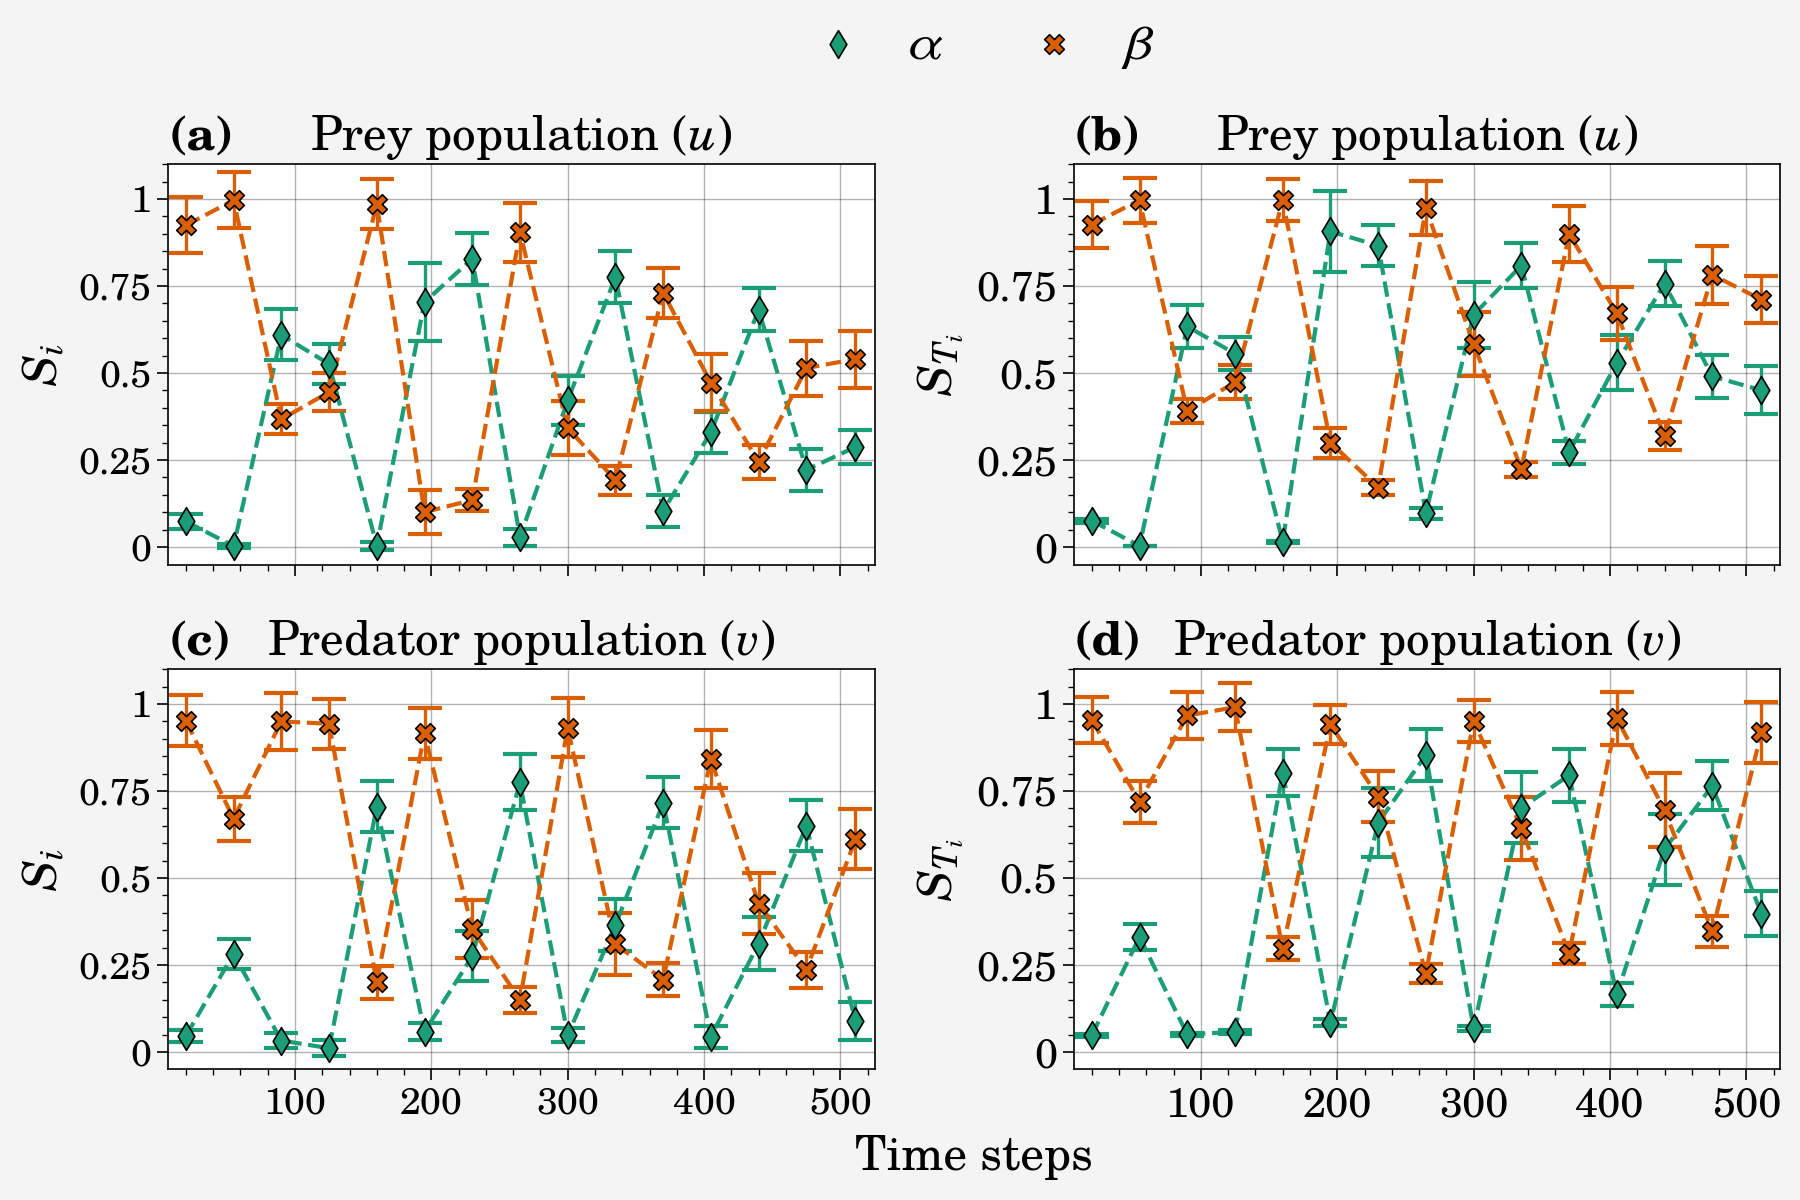

In [22]:
fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, sharey=False)

sobol_indices = [np.asarray(Si_u_S1), np.asarray(Si_u_ST), 
                 np.asarray(Si_v_S1), np.asarray(Si_v_ST)] 
sobol_ind_conf = [np.asarray(Si_u_S1_conf), np.asarray(Si_u_ST_conf),
                  np.asarray(Si_v_S1_conf), np.asarray(Si_v_ST_conf)]

for j, si in enumerate(sobol_indices):
    for i, param in enumerate(param_names):
        axs[j].scatter(steps, si[:, i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(steps, si[:, i], sobol_ind_conf[j][:, i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=6, alpha=1, elinewidth=1.2)
    
    for ax in axs:
        ax.format(xlim=(7, 525),
                  abc='a.', xlabel='Time steps')
                  
        if ax == axs[1] or ax == axs[3]:
            ax.format(ylabel=r'$S_{T_i}$',
                      ylim=(-0.05, 1.1), fontsize=15)
        else:
            ax.format(ylabel=r'$S_i$',
                     ylim=(-0.05, 1.1), )
            
        if ax == axs[0] or ax == axs[1]:
            ax.format(title=r'Prey population $(u)$')
        else:
            ax.format(title=r'Predator population $(v)$')
            
        ax.format(rc_kw={'title.size': 17,
                         'label.size': 17,
                         'abc.size': 17})
        
        
fig.legend(param_names, ncols=4, frame=False, loc='t', fontsize = 16)

axs.format(abc='(a)')

fig.tight_layout()
plt.savefig('plots/main_text/LV_2vars_SALib.pdf', bbox_inches='tight')
plt.show()

# 2. Sobol' indices: LV model with four uncertain parameters

## 2.1. GSA using GDMaps PCE

In [23]:
# probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
pdf3 = Uniform(loc=8, scale=10)  # c
pdf4 = Uniform(loc=8, scale=10)  # d

margs = [pdf1, pdf2, pdf3, pdf4]
joint = JointIndependent(marginals=margs)

In [24]:
# defining problem
problem = {
  'num_vars': 4, 
  'names': ['a', 'b', 'c', 'd'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18],
             [8, 18], 
             [8, 18]]
}

# Generate samples using saltelli from SALib
x = saltelli.sample(problem, 1024, calc_second_order=False)

# Timesteps array
n = 512 
t = np.linspace(0, 25,  n) 

out = []

for j in range(x.shape[0]):
    out_ = Lotka_Volterra(x[j, 0], x[j, 1], x[j, 2], x[j, 3], t)
    # keeping both species
    out_ = out_.T.flatten() 
    out.append(out_)

data = np.array(out)
data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [25]:
if not os.path.exists(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz'):
    start_time = time.time()

    # performing GDMAps
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                             n_evecs=20,
                                                             n_parsim=3, 
                                                             p=10).get() 

    print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    # performing PCE on the manifold
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=True).get()

    print('Error of PCE:', error)
    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()

    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
    
    np.savez(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz',
             x1 = pce_to_si, 
             x2 = pce_fo_si, 
             x3 = pce_gto_si, 
             x4 = pce_gfo_si,
             x5 = evals,
             x6 = evecs,
             x7 = coord,
             x8 = g,
             x9 = residuals,
             x10 = index,
             x11 = error)
else:
    file_res = np.load(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz', 
                       allow_pickle=True)
    
    pce_to_si = file_res['x1']
    pce_fo_si = file_res['x2']
    pce_gto_si = file_res['x3']
    pce_gfo_si = file_res['x4']       
    evals = file_res['x5'] 
    evecs = file_res['x6'] 
    coord = file_res['x7'] 
    g = file_res['x8']    
    residuals = file_res['x9'] 
    index = file_res['x10']    
    error = file_res['x11']



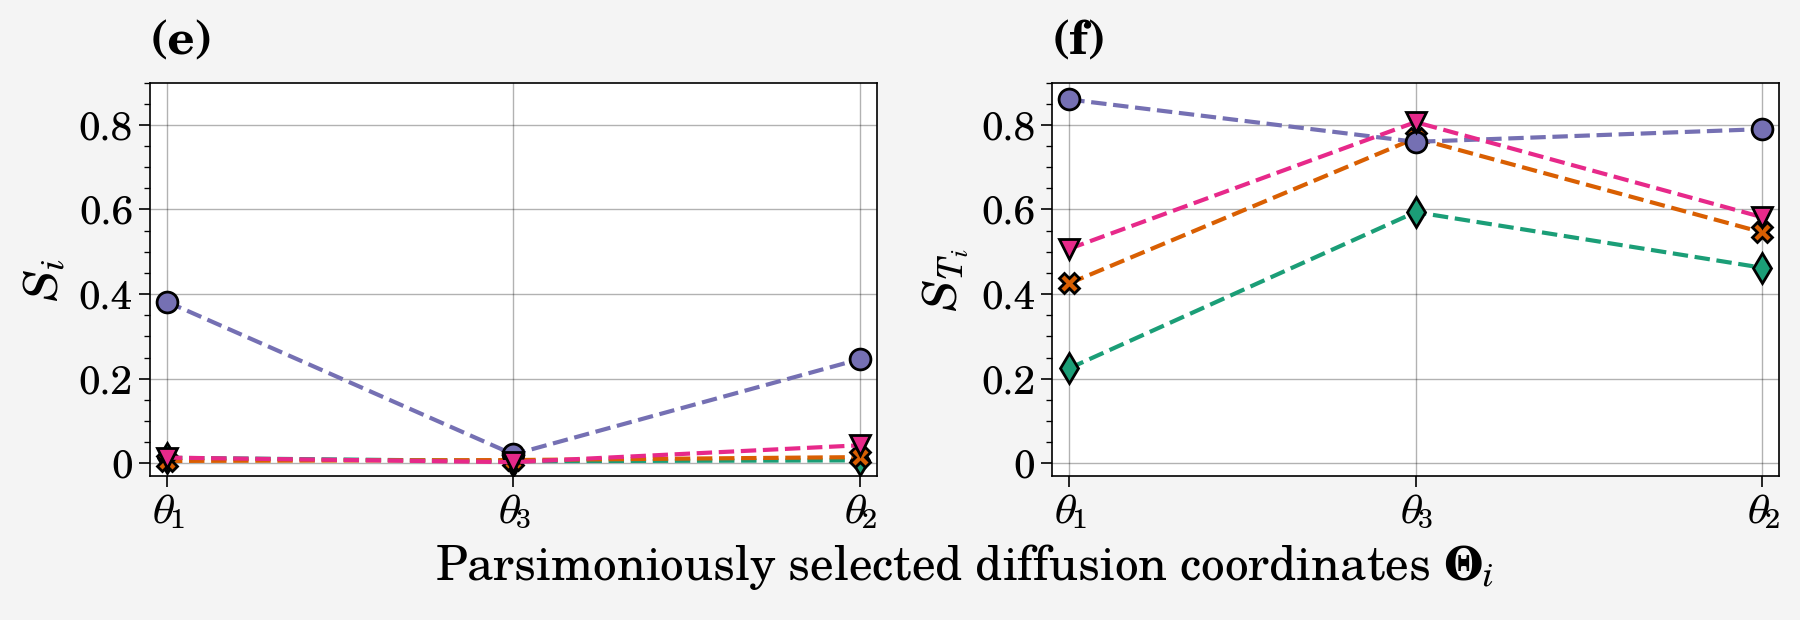

In [26]:
param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
param_styles = ['d--', 'X--', 'o--',  'v--', 'P--', 's--','*--']
colors=mcp.gen_color(cmap="Dark2",n=9)

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(9, 3.1), sharex=True, sharey=False)


for i, param in enumerate(param_names):
    axs[0].plot(np.linspace(1, 3, 3, dtype='int'), pce_fo_si[i], param_styles[i],
                label=param_names[i], color=colors[i], markeredgecolor='k', markersize=7.5)
    axs[1].plot(np.linspace(1, 3, 3, dtype='int'), pce_to_si[i], param_styles[i],
                label=param_names[i], color=colors[i], markeredgecolor='k', markersize=7.5)
    
    for ax in axs:
        ax.format(xticklabels=[r'$\theta_{{{}}}$'.format(c) for i, c in enumerate(coord)],
                  xticks = [1, 2, 3], xlim=(0.95, 3.05), ylim=(-0.03, 0.9),
                  xlabel=r'Parsimoniously selected diffusion coordinates $\bf{\Theta}$$_i$')
                  
        if ax == axs[1]:
            ax.format(ylabel=r'$S_{T_i}$', title='(f)', 
                      titleloc='left', titlepad=10, titleweight='bold')
        else:
            ax.format(ylabel=r'$S_i$', title='(e)', 
                      titleloc='left', titlepad=10, titleweight='bold')
            
        ax.format(rc_kw={'title.size': 17,
                         'label.size': 17,
                         'tick.labelsize': 14})

fig.tight_layout()
plt.savefig('plots/SI/LV_PCE_GSA.pdf', bbox_inches='tight')
plt.show()


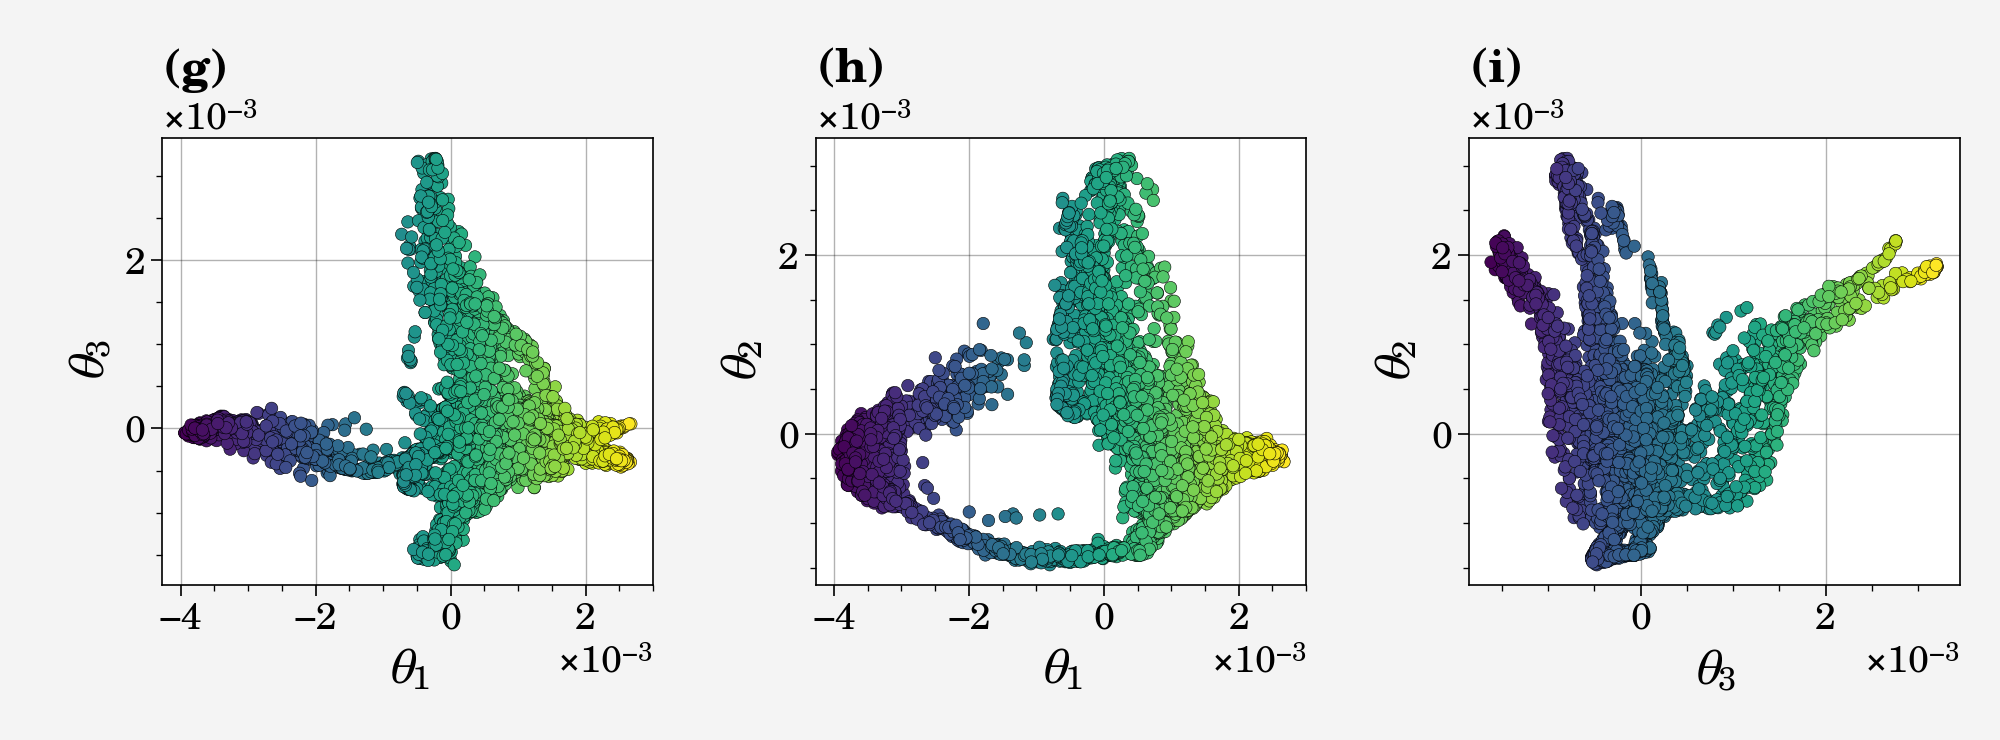

In [31]:
# plotting diffusion coordinates

pplt.rc['grid.linewidth'] = 0.5
pplt.rc['grid.alpha'] = 0.3

numbering= ['(g)', '(h)', '(i)']

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.7), constrained_layout=True)
    for i in range(len(comb1)):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                      cmap='viridis', s=20, 
                      edgecolors='k', 
                      linewidth=0.2)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[i][0]), fontsize=17)
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[i][1]), fontsize=17)
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        ax[i].set_title(r'$\bf{{{}}}$'.format(numbering[i]), loc='left', pad=20, size=17)
    fig.tight_layout()
    plt.savefig('plots/SI/LV_PCE_dcoords.png', dpi=800, bbox_inches='tight')
    plt.show()
    

## 2.2. GSA using SALib (Saltelli's algorithm)

In [28]:
# defining problem
problem = {
  'num_vars': 4, 
  'names': ['a', 'b', 'c', 'd'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18],
             [8, 18], 
             [8, 18]]
}

# generating samples
param_vals = saltelli.sample(problem, 1024, calc_second_order=False)

# timesteps array
n = 512 
t = np.linspace(0, 25,  n)  
    
# lists storing the S1 and ST for different timesteps
Si_u_S1 = []
Si_u_ST = []
Si_u_S1_conf = []
Si_u_ST_conf = []

Si_v_S1 = []
Si_v_ST = []
Si_v_S1_conf = []
Si_v_ST_conf = []

steps = np.linspace(20, 511, 15, dtype='int')

if not os.path.exists(f'GSA_results/LV/4vars_SALib.npz'):
    for step in steps:
        # initializing matrix to store output
        Y = np.zeros([len(param_vals), 2])

        for i in range(param_vals.shape[0]):
            Y[i, :] = Lotka_Volterra(param_vals[i, 0], 
                                    param_vals[i, 1], 
                                    param_vals[i, 2], 
                                    param_vals[i, 3], 
                                    t)[step] # step in the loop

        # completing sobol analysis for each u and v separately
        Si_u = sobol.analyze(problem, Y[:,0], calc_second_order=False)
        Si_u_S1.append(Si_u['S1'])
        Si_u_ST.append(Si_u['ST'])
        Si_u_S1_conf.append(Si_u['S1_conf'])
        Si_u_ST_conf.append(Si_u['ST_conf'])

        Si_v = sobol.analyze(problem, Y[:,1], calc_second_order=False)
        Si_v_S1.append(Si_v['S1'])
        Si_v_ST.append(Si_v['ST'])
        Si_v_S1_conf.append(Si_v['S1_conf'])
        Si_v_ST_conf.append(Si_v['ST_conf'])
        
    np.savez(f'GSA_results/LV/4vars_SALib.npz',
                 x1 = Si_u_S1, 
                 x2 = Si_u_ST, 
                 x3 = Si_u_S1_conf, 
                 x4 = Si_u_ST_conf,
                 x5 = Si_v_S1,
                 x6 = Si_v_ST,
                 x7 = Si_v_S1_conf,
                 x8 = Si_v_ST_conf)
    
else:
    file_res = np.load(f'GSA_results/LV/4vars_SALib.npz', 
                       allow_pickle=True)
    
    Si_u_S1 = file_res['x1']
    Si_u_ST = file_res['x2']
    Si_u_S1_conf = file_res['x3']
    Si_u_ST_conf = file_res['x4']
    Si_v_S1 = file_res['x5']
    Si_v_ST = file_res['x6']
    Si_v_S1_conf = file_res['x7']
    Si_v_ST_conf = file_res['x8']


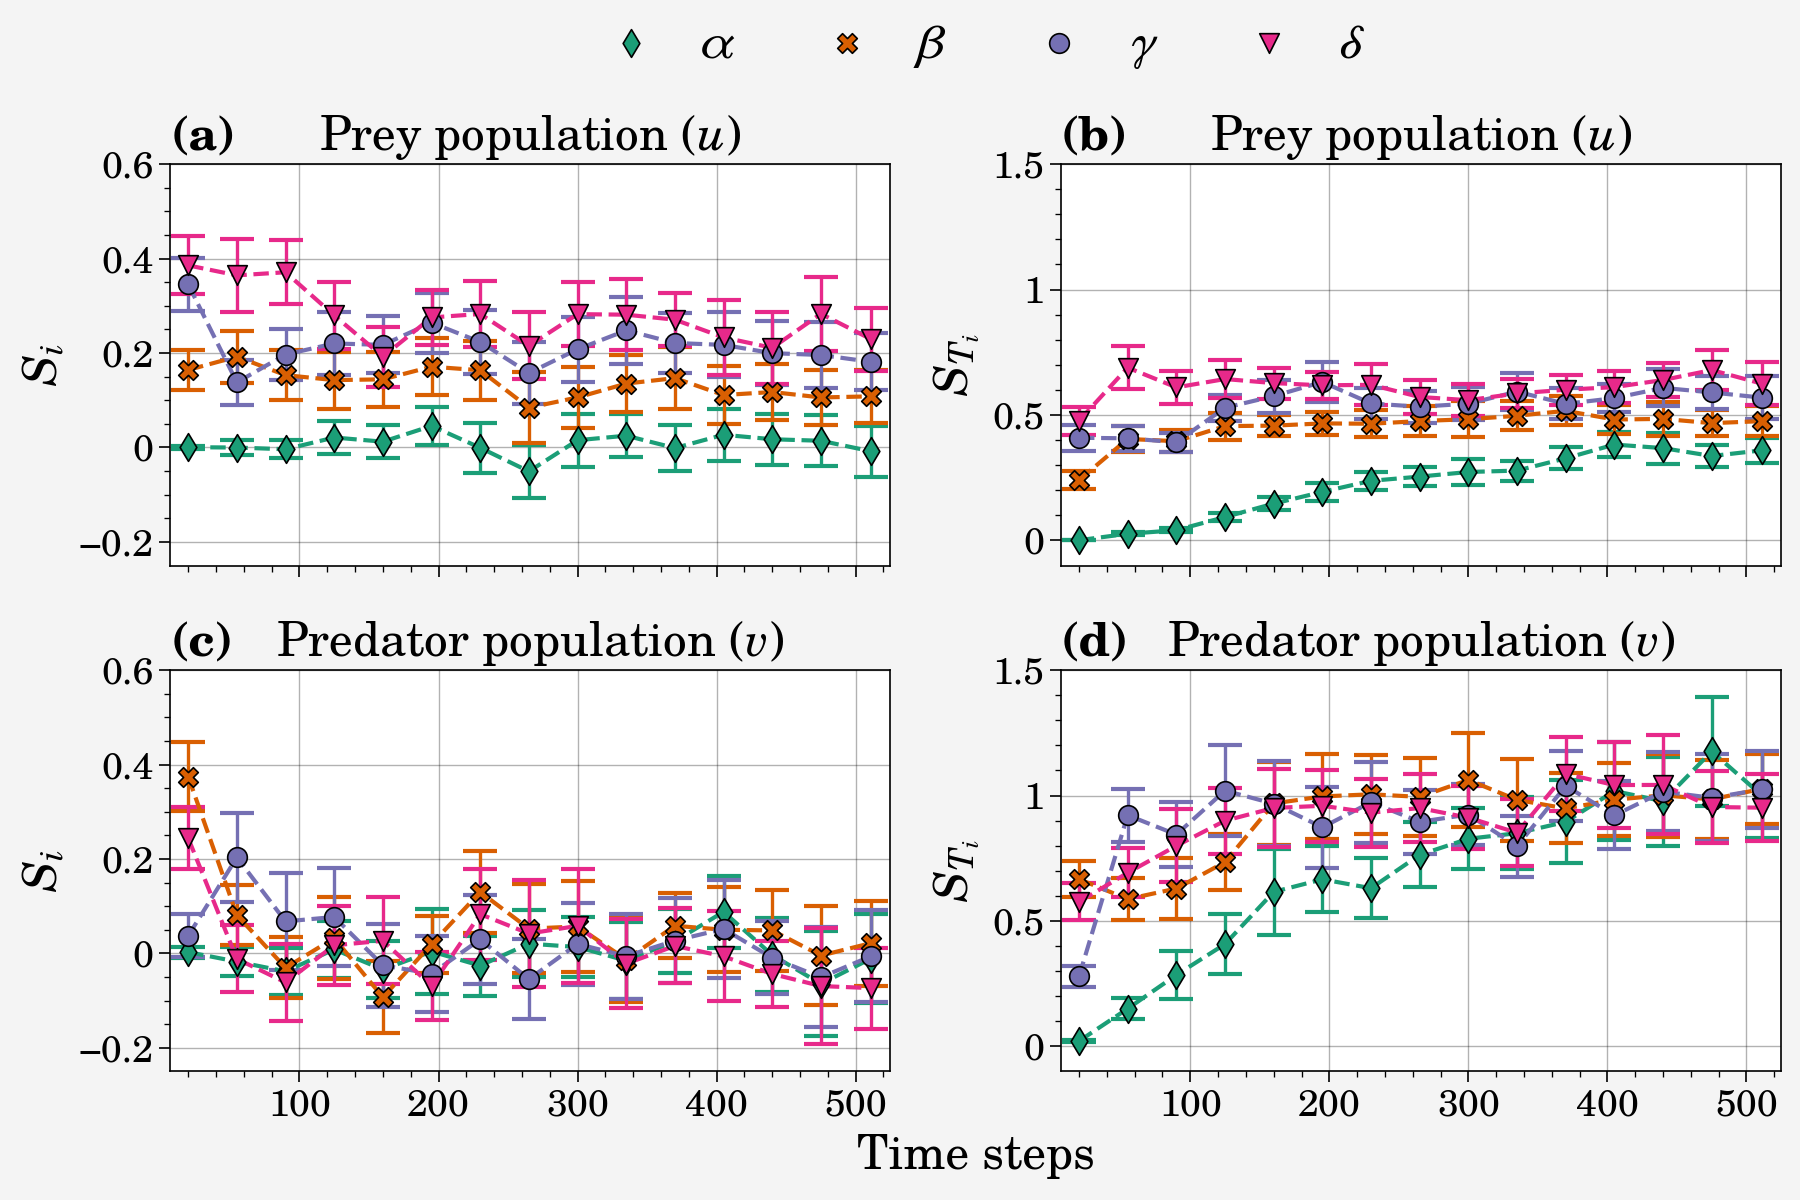

In [29]:
fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, sharey=False)

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
error_marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
colors=mcp.gen_color(cmap="Dark2",n=9)

sobol_indices = [np.asarray(Si_u_S1), np.asarray(Si_u_ST), 
                 np.asarray(Si_v_S1), np.asarray(Si_v_ST)] 
sobol_ind_conf = [np.asarray(Si_u_S1_conf), np.asarray(Si_u_ST_conf),
                  np.asarray(Si_v_S1_conf), np.asarray(Si_v_ST_conf)]

for j, si in enumerate(sobol_indices):
    for i, param in enumerate(param_names):
        axs[j].scatter(steps, si[:, i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(steps, si[:, i], sobol_ind_conf[j][:, i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=6, alpha=1, elinewidth=1.2)
    
    for ax in axs:
        ax.format(xlim=(7, 525),
                  abc='(a)', xlabel='Time steps')
                  
        if ax == axs[1] or ax == axs[3]:
            ax.format(ylabel=r'$S_{T_i}$',
                      ylim=(-0.1, 1.5))
        else:
            ax.format(ylabel=r'$S_i$',
                     ylim=(-0.25, 0.6))
            
        if ax == axs[0] or ax == axs[1]:
            ax.format(title=r'Prey population $(u)$')
        else:
            ax.format(title=r'Predator population $(v)$')
        
        ax.format(rc_kw={'title.size': 17,
                         'label.size': 17,
                         'abc.size': 17})
        
        
fig.legend(param_names, ncols=4, frame=False, loc='t', fontsize = 16)

fig.tight_layout()
plt.savefig('plots/SI/LV_SALib.pdf', bbox_inches='tight')
plt.show()